## Setup and Imports

Install ParametricModels package

In [1]:
!git clone -b master https://github.com/Flomastruk/ParametricModels.git
%cd ParametricModels/
!pip install .
%cd /content/

Cloning into 'ParametricModels'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 49 (delta 21), reused 39 (delta 14), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/ParametricModels
Processing /content/ParametricModels
  Created wheel for parametricmodels: filename=parametricmodels-0.0.0-cp36-none-any.whl size=6743 sha256=69a1674ae403aae07f6eed32a13c45646e843a320ecdcb8927a8fa4e7a5215df
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ijdv7nd/wheels/22/b1/93/fd07da854773fa99c0ba6fb43dd4d5c6db7d6f8381b6526743
Successfully built parametricmodels
/content


Import required packages and functionality

In [2]:
from collections import OrderedDict

import numpy as np
import tensorflow as tf

from parametricmodels.classes import ModelFromConcreteFunction
from parametricmodels.utils import ravel_dicts, plot_confidence_2d_projection, sq_loss

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Examples

Example I. Ordinary Least Squares regression

1. Define functional form

In [3]:
@tf.function
def linear_equation(input_features, params):
    return tf.squeeze(tf.matmul(input_features, params['W']))+ params['b']

2. Define the true process generating data

In [4]:
def linear_gaussian_simulation_scheme(X_mean, X_cov, params, y_ssq):
    def concrete_linear_simulation_scheme(num_samples):
        X_sim = np.random.multivariate_normal(mean = X_mean, cov = X_cov, size = num_samples).astype(np.float32)
        err = np.random.normal(loc = 0., size = num_samples, scale = np.sqrt(y_ssq)).astype(np.float32)
        y_sim = linear_equation(X_sim, params) + err

        return tf.Variable(X_sim) , y_sim
    return concrete_linear_simulation_scheme

In [ ]:
W0 = tf.Variable([[-.5],[.8]], dtype = tf.float32)
b0 = tf.Variable(1.0, dtype = tf.float32)
linear_params0 = OrderedDict({'W': W0, 'b': b0})

3. Define a model and assign simulation scheme 

In [ ]:
mc = ModelFromConcreteFunction(linear_equation, model_name = "ols_linear", params = linear_params0) # params keys must be compatible with linear equation

In [ ]:
X_cov = np.array([[1,.95], [.95,1]], dtype = np.float32)
mc.simulation_scheme = linear_gaussian_simulation_scheme(
    np.array([0., 0.], dtype = np.float32),
    X_cov,
    linear_params0,
    y_ssq = 9
    )

4. Generate data and fit the model

In [ ]:
num_samples = 1000
tmp_x, tmp_y = mc.simulation_scheme(num_samples)

In [ ]:
mc.optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)
mc.loss = sq_loss

In [ ]:
mc.fit(
    tmp_x, tmp_y
    , num_steps = tf.Variable(1000)
    , loss = sq_loss
    , params = linear_params0)

Retracing fit method
Retracing train step
Retracing train step


OrderedDict([('W', <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
              array([[-0.4855955],
                     [ 0.8169573]], dtype=float32)>),
             ('b', <tf.Tensor: shape=(), dtype=float32, numpy=1.0132556>)])

5. Access estimators

In [ ]:
mc.dldw2_plug_in_estimator(tmp_x, tmp_y, linear_params0, loss = sq_loss)
mc.d2ld2w_plug_in_estimator(tmp_x, tmp_y, linear_params0, loss = sq_loss)
cov_est = mc.parameter_covariance_plug_in_estimator(tmp_x, tmp_y, linear_params0, loss = sq_loss)

6. Simulate data and fit multiple models

In [ ]:
num_samples = 1000
mc.optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)

res = mc.fit_simulated_experiments(num_samples = num_samples
    , num_experiments = 100
    , num_steps = tf.Variable(2000)
    , params = linear_params0
    , loss = sq_loss
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Begin fitting simulated experiments...
Retracing fit method
Retracing train step
Retracing train step


100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


<function parametricmodels.utils.quadratic_form.<locals>.quad>

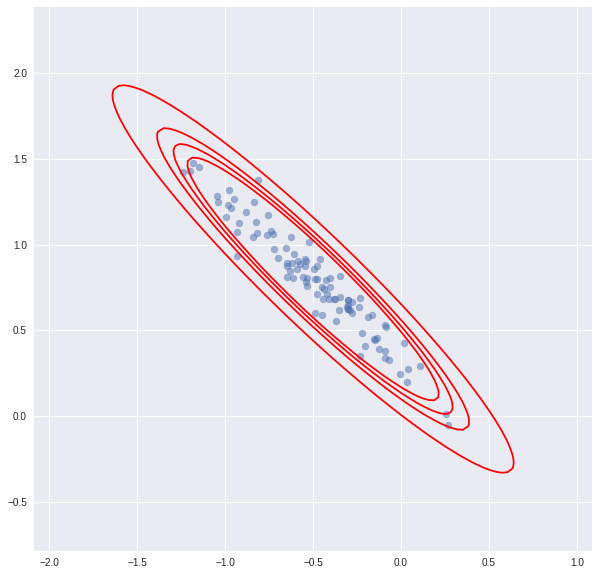

In [ ]:
m = ravel_dicts([linear_params0])
proj = np.eye(3,2)

plot_confidence_2d_projection(m.reshape(-1,1), cov_est, proj, ravel_dicts(res))

Example II. Weighted Least Squares regression

1. Define true process generating data

In [5]:
W1 = tf.Variable([[2.],[-1.2]], dtype = tf.float32)
b1 = tf.Variable(0.5, dtype = tf.float32)
linear_params1 = OrderedDict({'W': W1, 'b': b1})

2. Define a model and assign simulation scheme 

In [15]:
mcw = ModelFromConcreteFunction(linear_equation, model_name = "wls_linear", params = linear_params1) # params keys must be compatible with linear equation

In [16]:
X_cov = np.array([[1,.95], [.95,1]], dtype = np.float32)
mcw.simulation_scheme = linear_gaussian_simulation_scheme(
    np.array([0., 0.], dtype = np.float32),
    X_cov,
    linear_params1,
    y_ssq = 9
    )

3. Generate data and fit the model

In [8]:
num_samples = 1000
weights = np.concatenate([np.repeat(1., num_samples//10).astype(np.float32), np.repeat(0., num_samples - num_samples//10).astype(np.float32)]) # as if only 10% of data matters

tmp_x, tmp_y = mcw.simulation_scheme(num_samples)

In [ ]:
mcw.optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)
mcw.loss = sq_loss

In [ ]:
mcw.fit(
    tmp_x, tmp_y
    , num_steps = tf.Variable(1000)
    , loss = sq_loss
    , params = linear_params1
    , weights = weights)

Retracing fit method
Retracing train step
Retracing train step


OrderedDict([('W', <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
              array([[ 2.1284766],
                     [-1.0498931]], dtype=float32)>),
             ('b', <tf.Tensor: shape=(), dtype=float32, numpy=-0.23983544>)])

4. Access estimators

In [17]:
mcw.dldw2_plug_in_estimator(tmp_x, tmp_y, linear_params0, loss = sq_loss, weights = weights)
mcw.d2ld2w_plug_in_estimator(tmp_x, tmp_y, linear_params0, loss = sq_loss, weights = weights)
cov_est = mcw.parameter_covariance_plug_in_estimator(tmp_x, tmp_y, linear_params0, loss = sq_loss, weights = weights)

Retracing covariance estimation


5. Simulate data and fit multiple models

In [18]:
num_samples = 1000
mcw.optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)

res = mcw.fit_simulated_experiments(num_samples = num_samples
    , num_experiments = 100
    , num_steps = tf.Variable(2000)
    , params = linear_params1
    , loss = sq_loss
    , weights = weights
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Begin fitting simulated experiments...
Retracing fit method
Retracing train step
Retracing train step


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


<function parametricmodels.utils.quadratic_form.<locals>.quad>

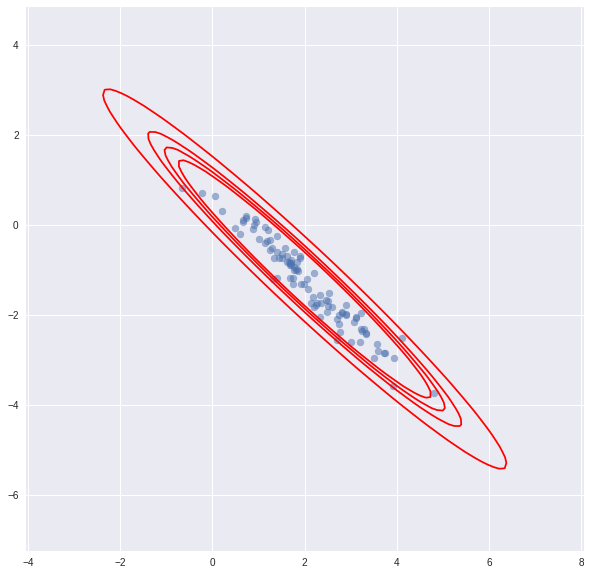

In [19]:
m = ravel_dicts([linear_params1])
proj = np.eye(3,2)

plot_confidence_2d_projection(m.reshape(-1,1), cov_est, proj, ravel_dicts(res))

Example III. Ordinary Least Squares with non-linear funcitonal form

1. Define functional form

In [20]:
@tf.function
def scurve_equation(input_features, params):
    return params['b'] + params['a']*tf.sigmoid(tf.squeeze(tf.matmul(input_features, params['W'])) + params['s'])

2. Define the true process generating data

In [62]:
def functional_gaussian_simulation_scheme(X_mean, X_cov, params, y_ssq, functional_equation):
    def concrete_functional_simulation_scheme(num_samples):
        X_sim = np.random.multivariate_normal(mean = X_mean, cov = X_cov, size = num_samples).astype(np.float32)
        err = np.random.normal(loc = 0., size = num_samples, scale = np.sqrt(y_ssq)).astype(np.float32)
        y_sim = functional_equation(X_sim, params) + err

        return tf.Variable(X_sim) , y_sim
    return concrete_functional_simulation_scheme

In [ ]:
a2 = tf.Variable(2., dtype = tf.float32)
b2 = tf.Variable(-.5, dtype = tf.float32)
s2 = tf.Variable(.0, dtype = tf.float32)
W2 = tf.Variable([[-.5],[.8]], dtype = tf.float32)

scurve_params2 = OrderedDict({'a': a2, 'b': b2, 's': s2, 'W': W2})

3. Define a model and assign simulation scheme 

In [69]:
mcs = ModelFromConcreteFunction(scurve_equation, model_name = "ols_scurve", params = scurve_params2)

In [70]:
X_cov = np.array([[10,9.5], [9.5,10]], dtype = np.float32)
mcs.simulation_scheme = functional_gaussian_simulation_scheme(
    np.array([0., 0.], dtype = np.float32),
    X_cov,
    scurve_params2,
    y_ssq = 1.,
    functional_equation = scurve_equation
    )

4. Access estimators

In [104]:
|num_samples = 1000
tmp_x, tmp_y = mcs.simulation_scheme(num_samples)

In [105]:
cov_est = mcs.parameter_covariance_plug_in_estimator(tmp_x, tmp_y, scurve_params2, loss = sq_loss)

5. Simulate data and fit multiple models

In [ ]:
mcs.optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)

res = mcs.fit_simulated_experiments(num_samples = num_samples
    , num_experiments = 100
    , num_steps = tf.Variable(2000)
    , params = scurve_params2
    , loss = sq_loss 
    )

<function parametricmodels.utils.quadratic_form.<locals>.quad>

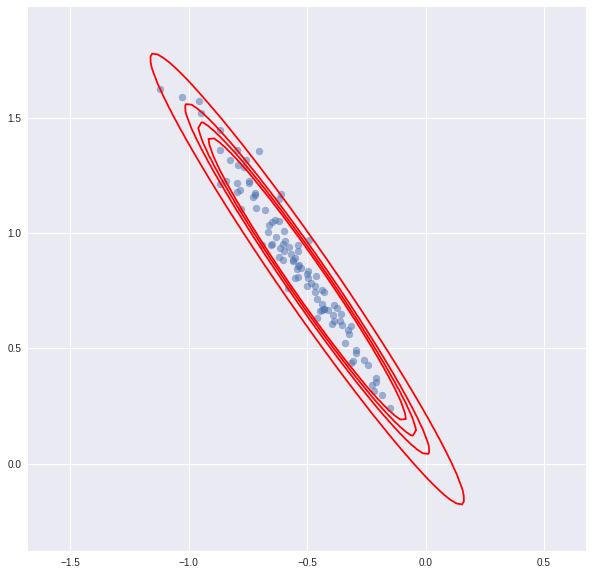

In [106]:
m = ravel_dicts([scurve_params2])
proj = np.eye(3,2)[[2,2,2,0,1]] # any projection matrix

plot_confidence_2d_projection(m.reshape(-1,1), cov_est, proj, ravel_dicts(res))

Example IV. Log-likelihood estimation of multivariate linear regression

1. Define loss function

In [113]:
@tf.function
def ll_gaussian_loss(labels, predictions, params):
    # note the sign is flipped for minimization problem
    # note constant = .5*tf.math.log(2*np.pi) is removed from the result
    ssq = tf.square(params['sigma'])
    return .5*tf.math.log(ssq) + .5*tf.square(labels - predictions)/ssq

2. Define the true process generating data

In [108]:
W3 = tf.Variable([[-.5],[.8]], dtype = tf.float32)
b3 = tf.Variable(1.0, dtype = tf.float32)
sigma = tf.Variable(3.0, dtype = tf.float32)

linear_params3 = OrderedDict({'W': W3, 'b': b3, 'sigma': sigma})

3. Define a model and assign simulation scheme 

In [109]:
mcl = ModelFromConcreteFunction(linear_equation, model_name = "ll_linear", params = linear_params3)

In [110]:
X_cov = np.array([[10, 9.5], [9.5,10]], dtype = np.float32)
mcl.simulation_scheme = linear_gaussian_simulation_scheme(
    np.array([0., 0.], dtype = np.float32),
    X_cov,
    linear_params3,
    y_ssq = sigma.numpy()**2
    )

4. Access estimators

In [115]:
num_samples = 1000
tmp_x, tmp_y = mcl.simulation_scheme(num_samples)

In [116]:
cov_est = mcl.parameter_covariance_plug_in_estimator(tmp_x, tmp_y, linear_params3, loss = ll_gaussian_loss) # note different loss function

Retracing covariance estimation


5. Simulate data and fit multiple models

In [ ]:
mcl.optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)

res = mcl.fit_simulated_experiments(num_samples = num_samples
    , num_experiments = 100
    , num_steps = tf.Variable(2000)
    , params = linear_params3
    , loss = ll_gaussian_loss
    )

<function parametricmodels.utils.quadratic_form.<locals>.quad>

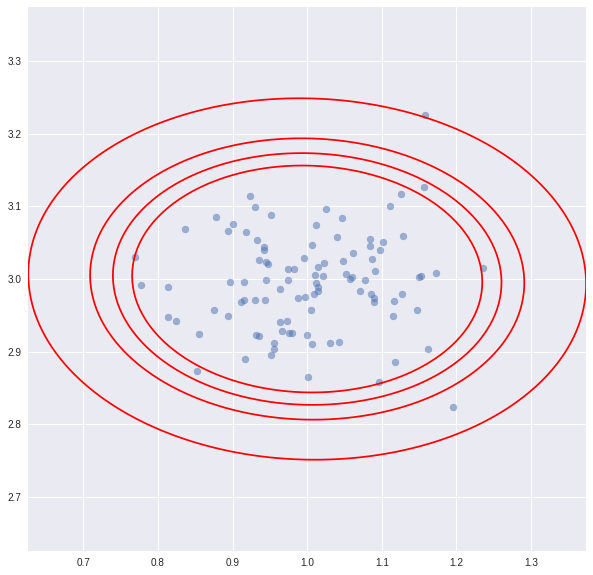

In [118]:
m = ravel_dicts([linear_params3])
proj = np.eye(3,2)[[2,2,0,1]] # any projection matrix

plot_confidence_2d_projection(m.reshape(-1,1), cov_est, proj, ravel_dicts(res))

Example V. Log-likelihood estimation of multivariate linear regression with heteroskedastic error

1. Define loss function

In [119]:
@tf.function
def ll_heteroskedastic_gaussian_loss(labels, predictions, features, params):
    # note the sign is flipped for minimization problem
    # note constant = .5*tf.math.log(2*np.pi) is removed from the result
    ssq = tf.square(tf.squeeze(tf.matmul(features, params['T'])) + params['sigma'])
    return .5*tf.math.log(ssq) + .5*tf.square(labels - predictions)/ssq

2. Define the true process generating data

In [120]:
def linear_heteroskedastic_gaussian_simulation_scheme(X_mean, X_cov, params):
    def concrete_linear_simulation_scheme(num_samples):
        X_sim = np.random.multivariate_normal(mean = X_mean, cov = X_cov, size = num_samples).astype(np.float32)
        err = np.random.normal(loc = 0., size = num_samples, scale = 1.).astype(np.float32)
        err*= tf.squeeze(X_sim @ params['T']) + params['sigma']
        y_sim = linear_equation(X_sim, params) + err

        return tf.Variable(X_sim) , y_sim
    return concrete_linear_simulation_scheme

In [121]:
W4 = tf.Variable([[-.5],[.8]], dtype = tf.float32)
b4 = tf.Variable(1.0, dtype = tf.float32)
T4 = tf.Variable([[1],[0]], dtype = tf.float32)
sigma4 = tf.Variable(3.0, dtype = tf.float32)
linear_params4 = OrderedDict({'W': W4, 'b': b4, 'T': T4, 'sigma': sigma4})

3. Define a model and assign simulation scheme 

In [122]:
mch = ModelFromConcreteFunction(linear_equation, model_name = "ll_heteroskedastic_linear", params = linear_params4, loss_from_features = True)

In [123]:
X_cov = np.array([[10, 9.5], [9.5,10]], dtype = np.float32)
mch.simulation_scheme = linear_heteroskedastic_gaussian_simulation_scheme(
    np.array([10., 10.], dtype = np.float32),
    X_cov,
    linear_params4,
    )

4. Access estimators

In [124]:
num_samples = 1000
tmp_x, tmp_y = mch.simulation_scheme(num_samples)

In [126]:
cov_est = mch.parameter_covariance_plug_in_estimator(tmp_x, tmp_y, linear_params4, loss = ll_heteroskedastic_gaussian_loss) # note different loss function

Retracing covariance estimation


5. Simulate data and fit multiple models

In [127]:
mch.optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)

res = mch.fit_simulated_experiments(num_samples = num_samples
    , num_experiments = 100
    , num_steps = tf.Variable(4000)
    , params = linear_params4
    , loss = ll_heteroskedastic_gaussian_loss
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Begin fitting simulated experiments...
Retracing fit method
Retracing train step
Retracing train step


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


<function parametricmodels.utils.quadratic_form.<locals>.quad>

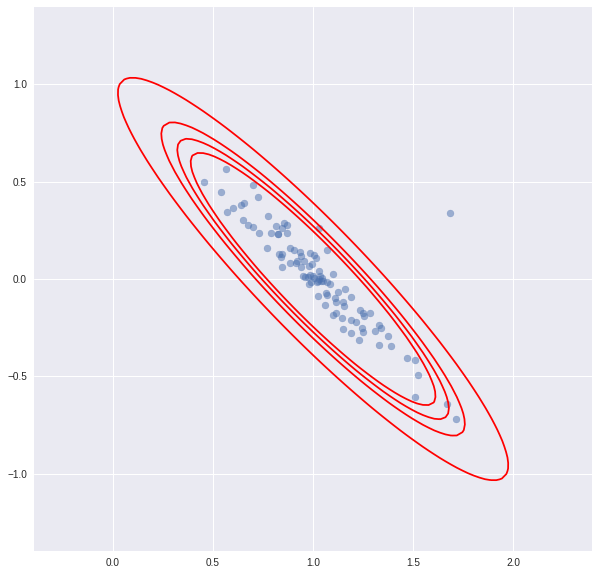

In [128]:
m = ravel_dicts([linear_params4])
proj = np.eye(3,2)[[2,2,2,0,1,2]]

plot_confidence_2d_projection(m.reshape(-1,1), cov_est, proj, ravel_dicts(res))